In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

# Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create datasets

#### flow from directory function
Requires a specific folder structure for dataset. Different classes should be placed in different sub-folders but inside the same parent folder. Downloading kaggle's cats and dog dataset using this [link](https://www.microsoft.com/en-us/download/details.aspx?id=54765) provides the following dataset structure:

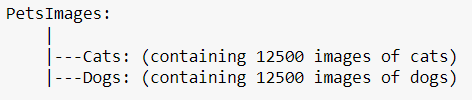

In order to use flow_from_directory method, we need to change it to the following:

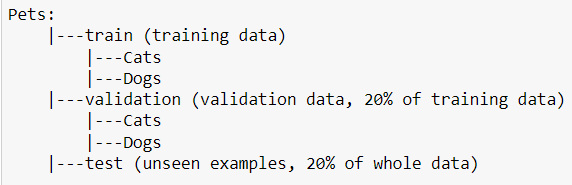

The following script automates the process. Download the dataset and put the "PetsImage" in the project root.

**NOTE** Choose one of the methods flow_from_directory or flow_from_dataframe; meaning run one of the two blocks blow.

In [ ]:
import os
import random
import shutil
from math import floor

# creating required directories
required_dirs = ['Pets','./Pets/train','./Pets/test','./Pets/validation','./Pets/train/Cat','./Pets/test/Cat',
                 './Pets/validation/Cat', './Pets/train/Dog','./Pets/test/Dog','./Pets/validation/Dog']
for directory in required_dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)


def split_train_validation_test(dataset_path, class_name):
    '''
    gets dataset path for each class and the class name,
    splits dataset classes into 3 subsets: train, validation, test
        - test dataset consists of 20% of whole data. assuming 100 images for whole class, 20 images will go to test subset.
        - validation dataset consists of 20% of remaining data, therefore 16 images will go to validation subset.
        - train dataset consists of the remaing data. (64 images in our prevision assumption.)
    '''
    for file in os.listdir(dataset_path):
        if not file.endswith('.jpg'):
            os.remove(dataset_path + file)

    for i in range(0,floor(0.2 * len(os.listdir(dataset_path)))):
        test_file = random.choice(os.listdir(dataset_path))
        shutil.copy(dataset_path+test_file, './Pets/test/' + class_name+'/'+test_file)
        os.remove(dataset_path+test_file)

    for j in range(0,floor(0.2 * len(os.listdir(dataset_path)))):
        v_file = random.choice(os.listdir(dataset_path))
        shutil.copy(dataset_path+v_file, './Pets/validation/' + class_name+'/'+v_file)
        os.remove(dataset_path+v_file)
    
    for file in os.listdir(dataset_path):
        shutil.copy(dataset_path+file, './Pets/train/' + class_name+'/'+file)
        os.remove(dataset_path+file)
        

# spliting data, since we only have two class:        
split_train_validation_test("./PetImages/Cat/",'Cat')
split_train_validation_test("./PetImages/Dog/",'Dog')

#### flow from dataframe

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# creating dataframe
file_names=[]
category=[]
cat_path ='./PetImages/Cat/'
dog_path ='./PetImages/Dog/'
for file in os.listdir(cat_path):
    if not file.endswith('.jpg'):
        os.remove(cat_path + file)
    else:
        file_names.append('Cat/'+str(file))
        category.append("0")
    
for file in os.listdir(dog_path):
    if not file.endswith('.jpg'):
        os.remove(dog_path + file)
    else:
        file_names.append('Dog/'+str(file))
        category.append("1")

df = pd.DataFrame({
        'filename': file_names,
        'category': category
    })


# spliting test, validation, and train datasets
train_x, test_x, train_y, test_y = train_test_split(df['filename'], df['category'], 
                                                  test_size = 0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                                                  test_size = 0.2)

# creating test, validation, and train dataframes
df_train = pd.DataFrame({
        'filename': train_x,
        'category': train_y
    })

df_val = pd.DataFrame({
        'filename': val_x,
        'category': val_y
    })

df_test = pd.DataFrame({
        'filename': test_x,
        'category': test_y
    })

#### create datasets

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Training Set
train_set = train_datagen.flow_from_directory('./Pets/train/',
                                             target_size=(128,128),
                                             batch_size=32,
                                             class_mode='binary')
#Validation Set
validation_set = test_datagen.flow_from_directory('./Pets/validation/',
                                           target_size=(128,128),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)

#Test Set
test_set = test_datagen.flow_from_directory('./Pets/test/',
                                           target_size=(128,128),
                                           class_mode="binary",
                                           shuffle=False)

Found 15998 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Model Architecture

In [5]:
from warnings import filterwarnings
filterwarnings('ignore')
classifier = Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=1,activation='sigmoid'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
classifier.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])


In [6]:
from PIL import Image

# Training
history = classifier.fit(train_set,
                        steps_per_epoch=400, 
                        epochs = 200,
                        validation_data = validation_set,
                        validation_steps = 20
                        );

#Some Helpful Instructions:

#finetune you network parameter in last by using low learning rate like 0.00001
#classifier.save('resources/dogcat_model_bak.h5')
#from tensorflow.keras.models import load_model
#model = load_model('partial_trained1')
#100 iteration w-5 ith learning rate 0.001 and after that 0.0001

Epoch 1/200
400/400 [==============================] - 320s 764ms/step - loss: 0.6340 - accuracy: 0.6239 - val_loss: 0.6493 - val_accuracy: 0.6625
Epoch 2/200
400/400 [==============================] - 84s 209ms/step - loss: 0.5207 - accuracy: 0.7400 - val_loss: 0.3559 - val_accuracy: 0.8562
Epoch 3/200
400/400 [==============================] - 62s 155ms/step - loss: 0.4687 - accuracy: 0.7772 - val_loss: 0.3859 - val_accuracy: 0.8438
Epoch 4/200
400/400 [==============================] - 56s 140ms/step - loss: 0.4342 - accuracy: 0.7977 - val_loss: 0.3872 - val_accuracy: 0.8344
Epoch 5/200
400/400 [==============================] - 54s 134ms/step - loss: 0.4096 - accuracy: 0.8110 - val_loss: 0.3915 - val_accuracy: 0.8328
Epoch 6/200
400/400 [==============================] - 54s 135ms/step - loss: 0.3846 - accuracy: 0.8251 - val_loss: 0.3720 - val_accuracy: 0.8250
Epoch 7/200
400/400 [==============================] - 53s 133ms/step - loss: 0.3631 - accuracy: 0.8374 - val_loss: 0.4121 

Epoch 57/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0611 - accuracy: 0.9778 - val_loss: 0.8558 - val_accuracy: 0.8109
Epoch 58/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0531 - accuracy: 0.9811 - val_loss: 0.9619 - val_accuracy: 0.7953
Epoch 59/200
400/400 [==============================] - 55s 137ms/step - loss: 0.0471 - accuracy: 0.9835 - val_loss: 0.8690 - val_accuracy: 0.8141
Epoch 60/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0469 - accuracy: 0.9834 - val_loss: 0.9423 - val_accuracy: 0.8219
Epoch 61/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0596 - accuracy: 0.9787 - val_loss: 0.7219 - val_accuracy: 0.8422
Epoch 62/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0516 - accuracy: 0.9809 - val_loss: 0.7861 - val_accuracy: 0.8453
Epoch 63/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0475 - accuracy: 0.9835 - val_loss: 0

400/400 [==============================] - 53s 133ms/step - loss: 0.0185 - accuracy: 0.9940 - val_loss: 1.8871 - val_accuracy: 0.7781
Epoch 168/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 1.0821 - val_accuracy: 0.8594
Epoch 169/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0183 - accuracy: 0.9939 - val_loss: 1.5055 - val_accuracy: 0.8109
Epoch 170/200
400/400 [==============================] - 54s 134ms/step - loss: 0.0193 - accuracy: 0.9930 - val_loss: 1.3009 - val_accuracy: 0.8266
Epoch 171/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 1.4605 - val_accuracy: 0.8203
Epoch 172/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0199 - accuracy: 0.9930 - val_loss: 1.3301 - val_accuracy: 0.8141
Epoch 173/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0226 - accuracy: 0.9918 - val_loss: 1.3971 -

Actually, I got this error trying to fit my model:

<font color='red'>cannot identify image file _io.BytesIO object at 0x000001E97F9D55E0 </font>

which indicates there are some corrupted files in the dataset. So, I ran the code below for each one of my directories with images; and deleted the corrupted file. If this was your case too, you'll need to create datasets again, since the corrupted files are still enlisted in those datasets.

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

image_dirs = ['./Pets/train/Cat/','./Pets/test/Cat/', './Pets/validation/Cat/', './Pets/train/Dog/',
                 './Pets/test/Dog/','./Pets/validation/Dog/']

for dirs in image_dirs:
    path = Path(dirs).rglob("*.jpg")
    for img_p in path:
        try:
            img = PIL.Image.open(img_p)
        except PIL.UnidentifiedImageError:
            print(img_p)

To tune the model further, we can train it again on top of the current tuned parameters. To achieve a more accurate model, we would reduce the learning rate. Although this increases the training time, it takes smaller steps toward the optimal point, more likely to achieve a better accuracy.

In [8]:
from PIL import Image

classifier.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
classifier.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

# Training 2
history = classifier.fit(train_set,
                        steps_per_epoch=400, 
                        epochs = 200,
                        validation_data = validation_set,
                        validation_steps = 20
                        );

Epoch 1/200
400/400 [==============================] - 48s 119ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 1.3727 - val_accuracy: 0.8391
Epoch 2/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0070 - accuracy: 0.9972 - val_loss: 1.3610 - val_accuracy: 0.8438
Epoch 3/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0042 - accuracy: 0.9983 - val_loss: 1.4736 - val_accuracy: 0.8281
Epoch 4/200
400/400 [==============================] - 54s 136ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 1.2846 - val_accuracy: 0.8422
Epoch 5/200
400/400 [==============================] - 54s 134ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 1.3239 - val_accuracy: 0.8484
Epoch 6/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 1.3687 - val_accuracy: 0.8375
Epoch 7/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 1.2728 -

Epoch 57/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 1.2918 - val_accuracy: 0.8687
Epoch 58/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 1.3737 - val_accuracy: 0.8625
Epoch 59/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 1.5846 - val_accuracy: 0.8422
Epoch 60/200
400/400 [==============================] - 53s 133ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 1.5328 - val_accuracy: 0.8484
Epoch 61/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 1.6316 - val_accuracy: 0.8438
Epoch 62/200
400/400 [==============================] - 53s 132ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 1.7482 - val_accuracy: 0.8344
Epoch 63/200
400/400 [==============================] - 53s 132ms/step - loss: 6.4301e-04 - accuracy: 0.9998 - val_los

Epoch 112/200
400/400 [==============================] - 54s 135ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 1.7658 - val_accuracy: 0.8547
Epoch 113/200
400/400 [==============================] - 54s 135ms/step - loss: 0.0020 - accuracy: 0.9992 - val_loss: 1.7050 - val_accuracy: 0.8562
Epoch 114/200
400/400 [==============================] - 54s 135ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.6688 - val_accuracy: 0.8609
Epoch 115/200
400/400 [==============================] - 54s 135ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 1.8888 - val_accuracy: 0.8422
Epoch 116/200
400/400 [==============================] - 56s 141ms/step - loss: 2.3830e-04 - accuracy: 0.9999 - val_loss: 1.7005 - val_accuracy: 0.8516
Epoch 117/200
400/400 [==============================] - 55s 137ms/step - loss: 7.4964e-04 - accuracy: 0.9998 - val_loss: 1.4173 - val_accuracy: 0.8734
Epoch 118/200
400/400 [==============================] - 56s 141ms/step - loss: 5.1699e-04 - accuracy: 0

In [9]:
classifier.save('./dog_n_cat_model_2.h5')

# classifier = load_model('./dog_n_cat_model.h5')

In [10]:
import pandas as pd
%matplotlib inline
import tensorflow
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model

# Testing the model on test_set
test_set.reset
ytesthat = classifier.predict_generator(test_set)
df = pd.DataFrame({
    'filename':test_set.filenames,
    'predict':ytesthat[:,0],
    'y':test_set.classes
})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(20)


,filename,predict,y,y_pred
0,Cat\0.jpg,0.67719,0,1
1,Cat\10.jpg,0.00000,0,0
2,Cat\10005.jpg,0.00000,0,0
3,Cat\10009.jpg,0.00000,0,0
4,Cat\10010.jpg,0.80164,0,1
5,Cat\10011.jpg,0.60874,0,1
6,Cat\10012.jpg,0.00000,0,0
7,Cat\10014.jpg,0.00000,0,0
8,Cat\10027.jpg,0.08360,0,0
9,Cat\10029.jpg,0.00000,0,0


In [12]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 666


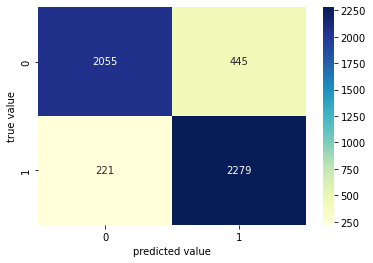

In [14]:
#Prediction of test set
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [13]:
# %%capture
# Model Accuracy
x1 = classifier.evaluate_generator(train_set)
x2 = classifier.evaluate_generator(validation_set)
x3 = classifier.evaluate_generator(test_set)
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))
print('Test Accuracy: %1.2f%%           Test loss: %1.6f'%(x3[1]*100,x3[0]))

Training Accuracy  : 99.98%     Training loss  : 0.000726
Validation Accuracy: 86.68%     Validation loss: 1.485540
Test Accuracy: 86.68%           Test loss: 1.509541
